In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier

In [21]:
data_df = pd.read_csv('train.csv')
data_df.head()

,Unnamed: 0,title,author,genre,format,num_of_pages,language,good
0,0,To Kill a Mockingbird,Harper Lee,Classics,Paperback,324,English,True
1,1,Harry Potter and the Sorcerer's Stone,J.K. Rowling,Fantasy,Hardcover,322,English,True
2,2,1984,George Orwell,Classics,Mass Market Paperback,328,English,True
3,3,Pride and Prejudice,Jane Austen,Classics,Paperback,279,English,True
4,4,The Diary of a Young Girl,Anne Frank,Nonfiction,Mass Market Paperback,283,English,True


In [22]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598 entries, 0 to 3597
Data columns (total 8 columns):
Unnamed: 0      3598 non-null int64
title           3596 non-null object
author          3596 non-null object
genre           3491 non-null object
format          3572 non-null object
num_of_pages    3598 non-null int64
language        3406 non-null object
good            3598 non-null bool
dtypes: bool(1), int64(2), object(5)
memory usage: 200.4+ KB


In [23]:
y_sr = data_df["good"] # sr là viết tắt của series
X_df = data_df.drop("good", axis=1)

In [24]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.3, 
                                                              stratify=y_sr, random_state=0)

train_X_df.head().index

Int64Index([9, 3497, 1720, 3289, 1374], dtype='int64')

In [25]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2518 entries, 9 to 1442
Data columns (total 7 columns):
Unnamed: 0      2518 non-null int64
title           2516 non-null object
author          2516 non-null object
genre           2444 non-null object
format          2497 non-null object
num_of_pages    2518 non-null int64
language        2384 non-null object
dtypes: int64(2), object(5)
memory usage: 157.4+ KB


In [26]:
val_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 861 to 3491
Data columns (total 7 columns):
Unnamed: 0      1080 non-null int64
title           1080 non-null object
author          1080 non-null object
genre           1047 non-null object
format          1075 non-null object
num_of_pages    1080 non-null int64
language        1022 non-null object
dtypes: int64(2), object(5)
memory usage: 67.5+ KB


In [27]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        # YOUR CODE HERE
        new_X = X_df.drop(columns=['title', 'author', 'Unnamed: 0'])
        return new_X

In [29]:
col_adderdropper = ColAdderDropper()
fewer_cols_train_X_df = col_adderdropper.transform(train_X_df)
fewer_cols_train_X_df.head()

,genre,format,num_of_pages,language
9,Fantasy,Paperback,1216,English
3497,NaN,Kindle Edition,277,English
1720,Fiction,Kindle Edition,371,English
3289,Classics,Paperback,660,English
1374,Fiction,Paperback,302,English


In [32]:
cols = ['genre', 'format', 'language']
# YOUR CODE HERE
preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cols)
)
scaler = StandardScaler(with_mean=False)
col_adderdropper = ColAdderDropper()
mlpclassifier = MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=500)
full_pipeline = make_pipeline(col_adderdropper, preprocess, scaler, mlpclassifier)

In [38]:
train_errs = []
val_errs = []
alphas = [0.0001, 0.1, 1, 10, 100, 1000]
layer_sizes = [10, 20, 30, 40, 50, 60]
best_val_err = float('inf'); best_alpha = None; best_size = None
for size in layer_sizes:
    for alpha in alphas:
        full_pipeline.set_params(mlpclassifier__alpha = alpha, mlpclassifier__hidden_layer_sizes = size)
        train_error = full_pipeline.fit(train_X_df, train_y_sr).score(train_X_df, train_y_sr)
        train_errs.append((1 - train_error) * 100)
        full_pipeline.predict(val_X_df)
        pred_error = 1 - full_pipeline.score(val_X_df, val_y_sr)
        val_errs.append(pred_error * 100) 
        if pred_error < best_val_err:
            best_val_err = pred_error
            best_alpha = alpha
            best_size = size
best_val_err = best_val_err * 100
'Finish!'

'Finish!'

In [40]:
print(best_val_err)
print(best_alpha)
print(best_size)

9.81481481481481
100
10


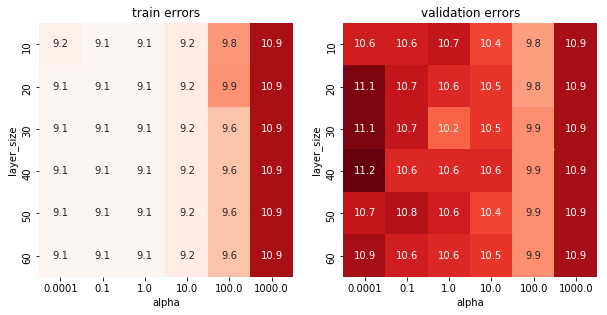

In [41]:
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=layer_sizes, columns=alphas)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=layer_sizes, columns=alphas)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('alpha'); plt.ylabel('layer_size')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('alpha'); plt.ylabel('layer_size');